In [1]:
from torch.utils.data import DataLoader
from utils.visualisation import visualise_image, plot_band_distribution
from utils.data import create_dataloaders, PlanetDataset
import torch
import config

device = config.device
DATA_PATH = config.PATH_TO_DATA

%load_ext autoreload
%autoreload 2

### Illustrate Data Loaders

In [6]:
train_loader, val_loader, test_loader = create_dataloaders(DATA_PATH, batch_size=4)

In [23]:
def illustrate_data_loader(loader, show_n_images: int):
    for i, (batch_sample, batch_masks) in enumerate(loader):
        image, label = batch_sample[0], batch_masks[0]
        label = label.unsqueeze(0)
        image, label = torch.permute(image, (1, 2, 0)), torch.permute(label, (1, 2, 0))
        visualise_image(image.numpy(), label.numpy())
        if i >= show_n_images:
            return
        
def speedtest_dataloader(size, same, num_workers=0, ):
    train_loader, _, _ = create_dataloaders(DATA_PATH, batch_size=size, batch_transforms=same, num_workers=num_workers)
    for x, y in train_loader: # iterate through one batch
        pass
    return

torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
Visualsing 4 examples
Proportion of Positive Pixels predicted:  tensor(0.0476)
Proportion of Positive Pixels in Mask:  tensor(0.0476)
Proportion of Positive Pixels predicted:  tensor(0.0561)
Proportion of Positive Pixels in Mask:  tensor(0.0561)
Proportion of Positive Pixels predicted:  tensor(0.1539)
Proportion of Positive Pixels in Mask:  tensor(0.1539)
Proportion of Positive Pixels predicted:  tensor(0.0483)
Proportion of Positive Pixels in Mask:  tensor(0.0483)


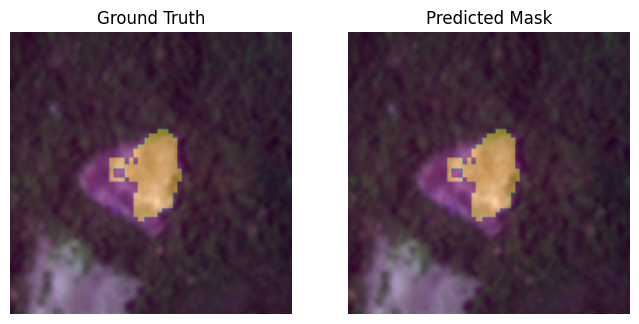

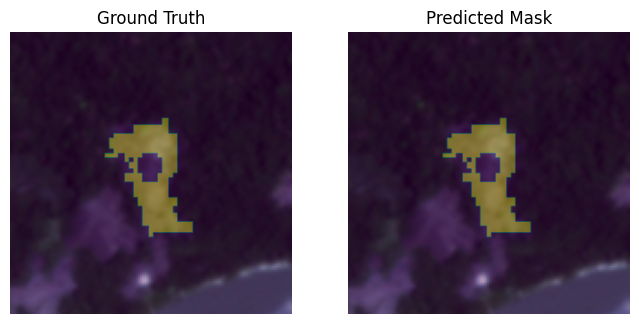

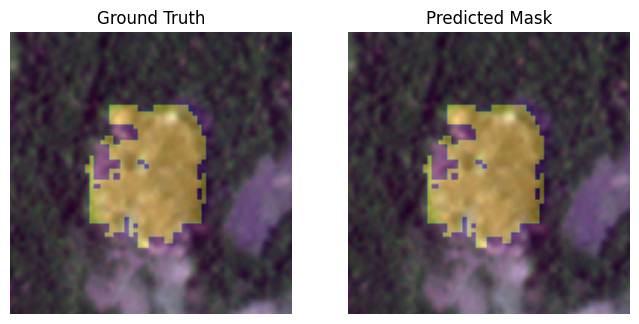

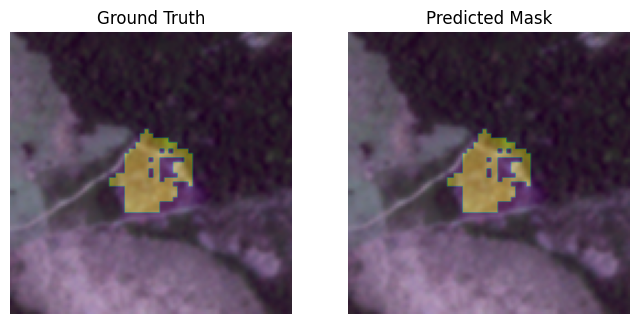

In [33]:
train_loader, val_loader, test_loader = create_dataloaders(DATA_PATH, batch_size=4, bands=[0,1 , 2], transforms=False)

batch_sample, batch_masks = next(iter(train_loader))
batch_masks = batch_masks.unsqueeze(1)

from utils.evaluation import show_results_tensor
print(batch_sample.shape)
print(batch_masks.shape)
show_results_tensor(batch_sample, batch_masks, batch_masks, bands=[0, 1, 2], rescale=False)

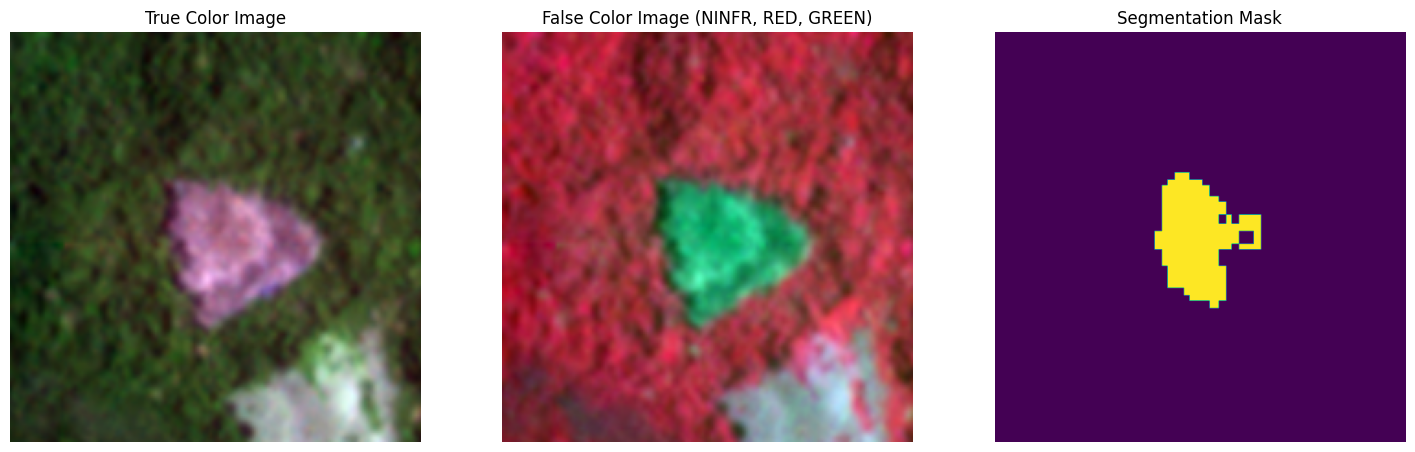

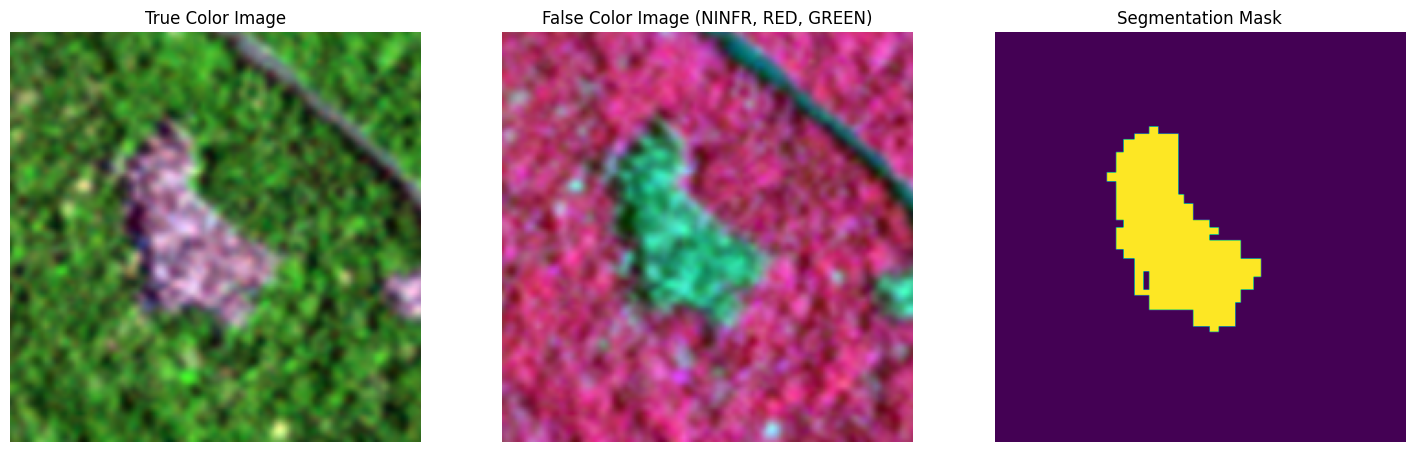

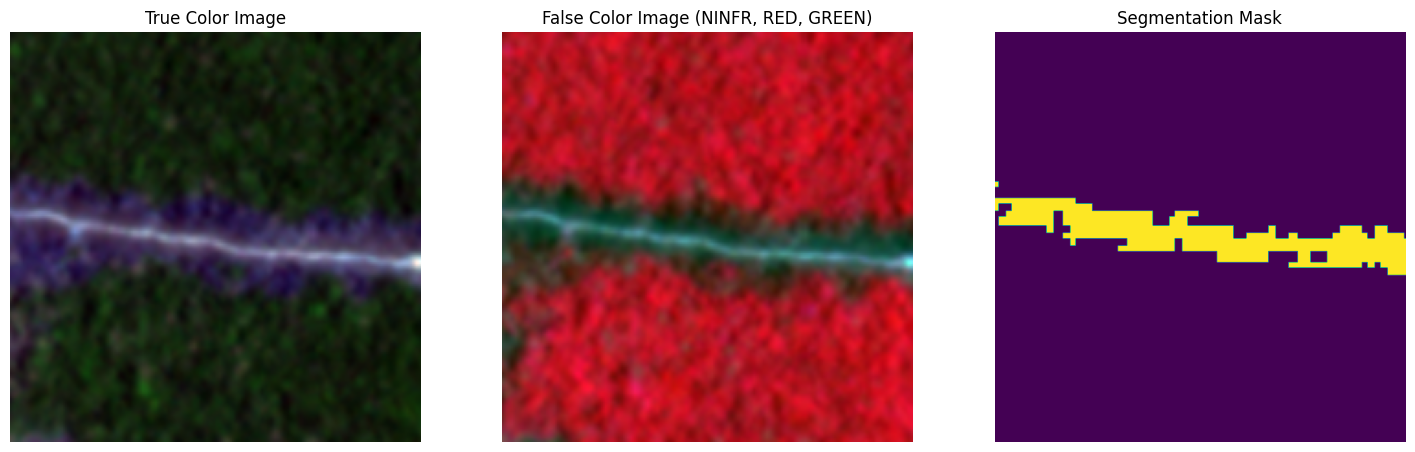

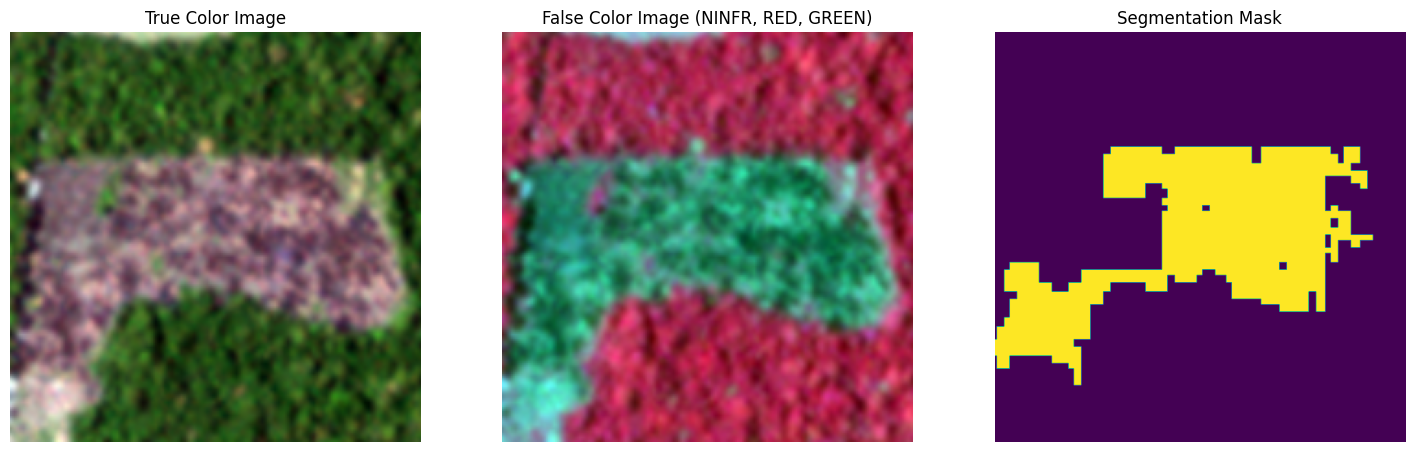

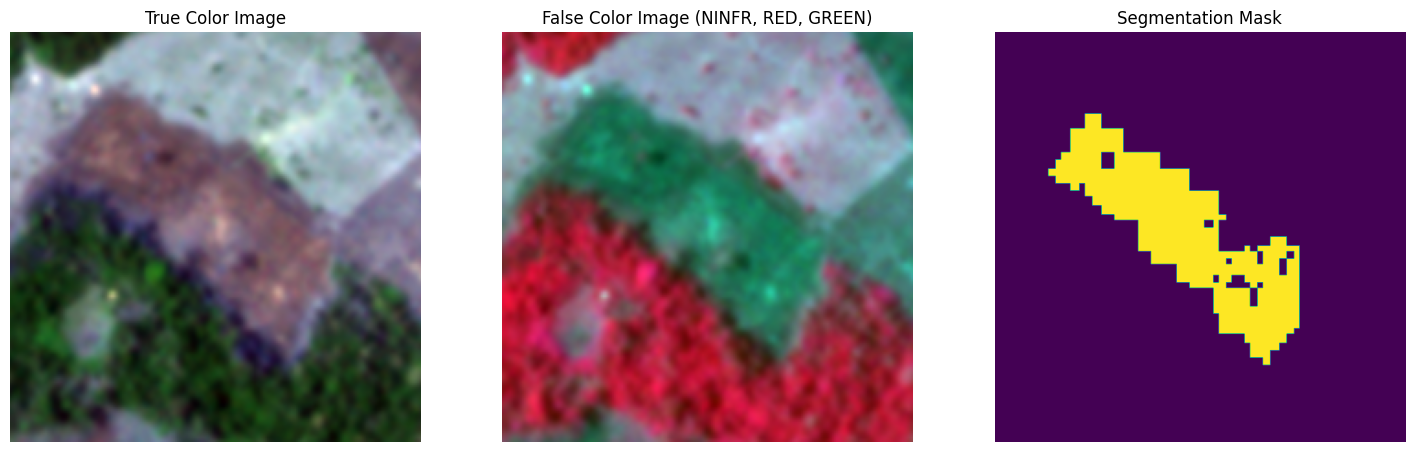

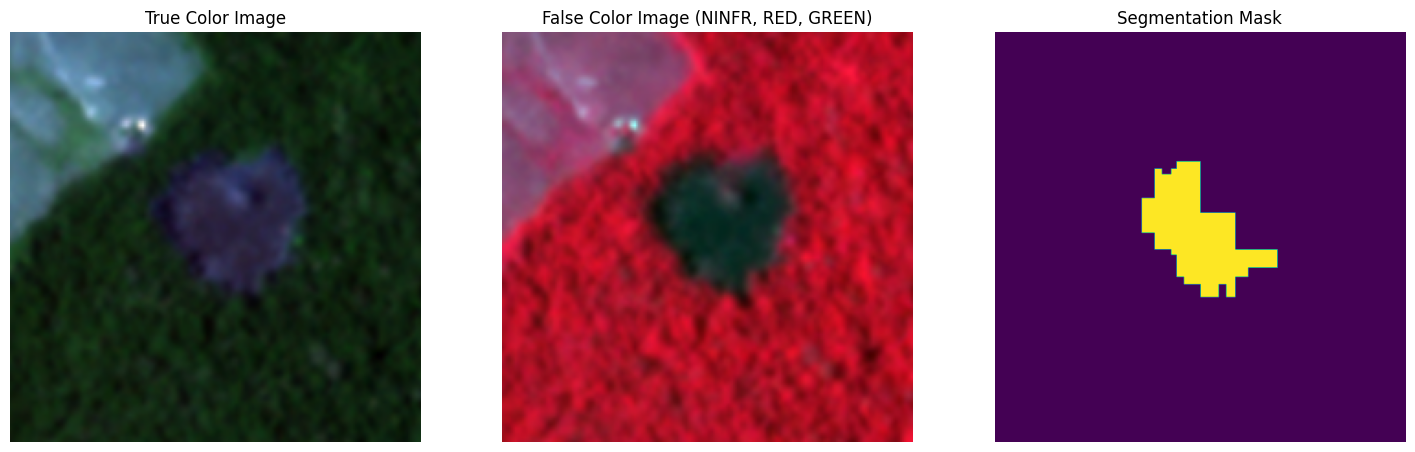

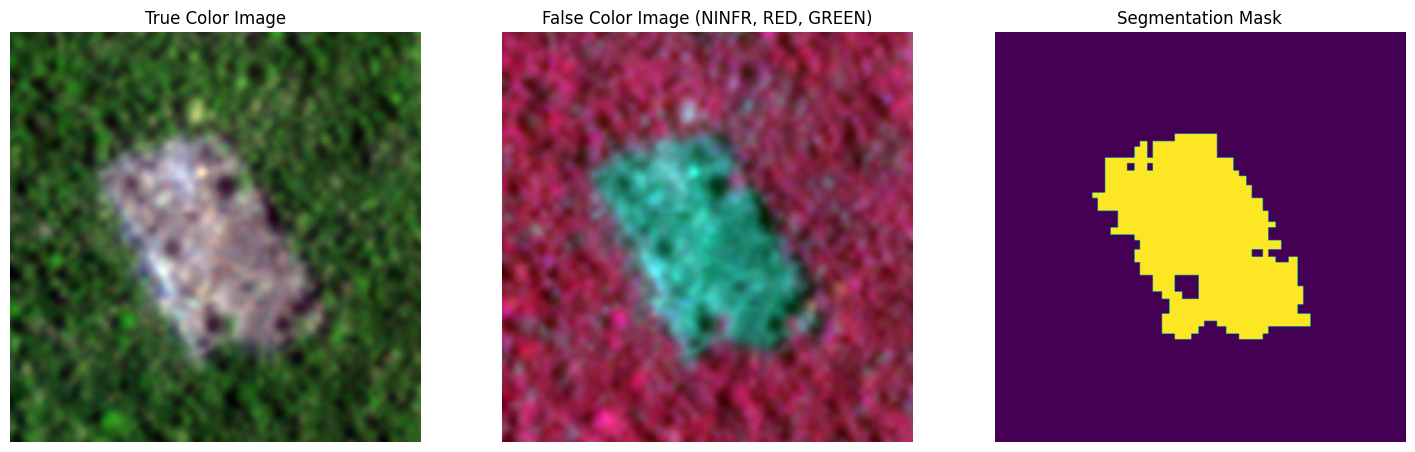

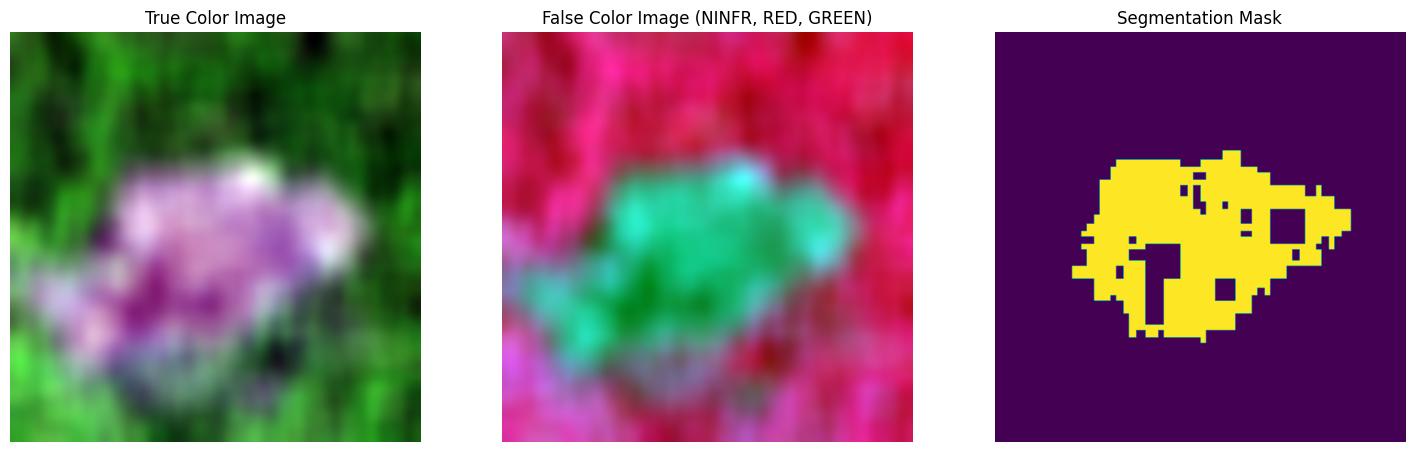

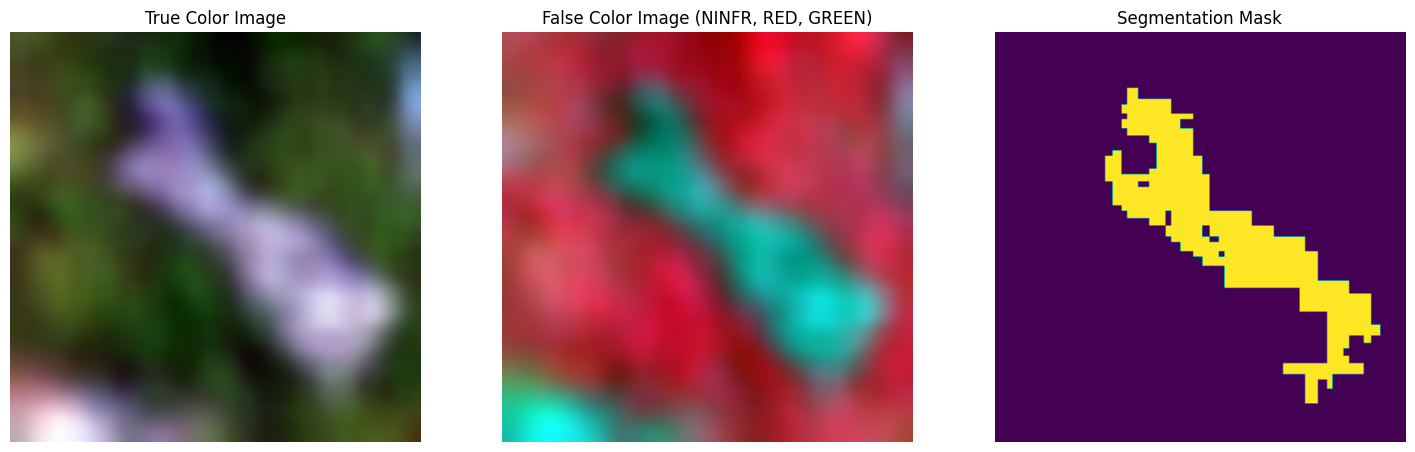

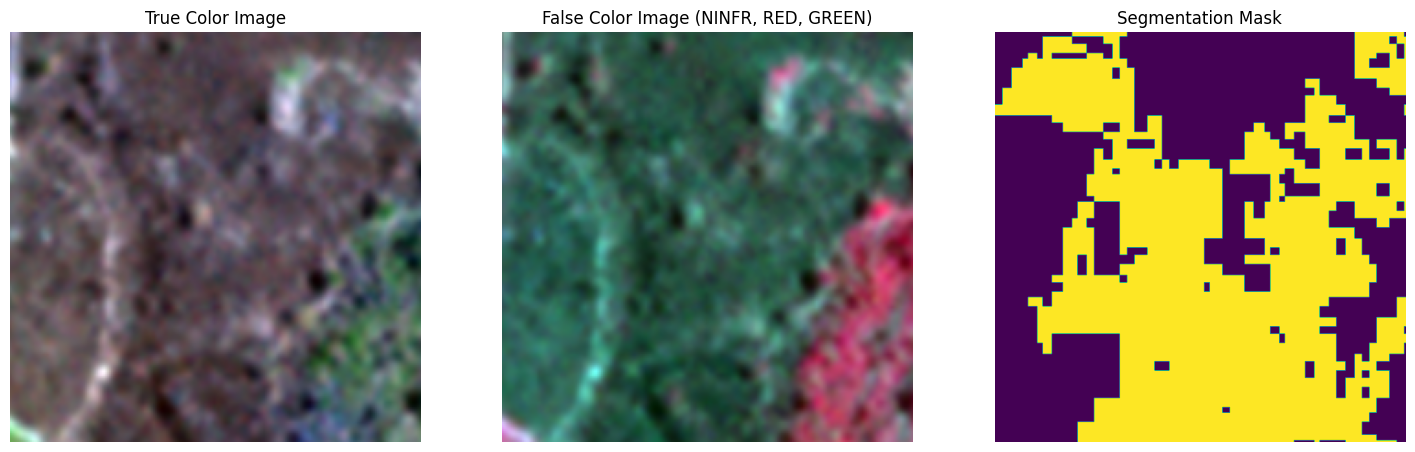

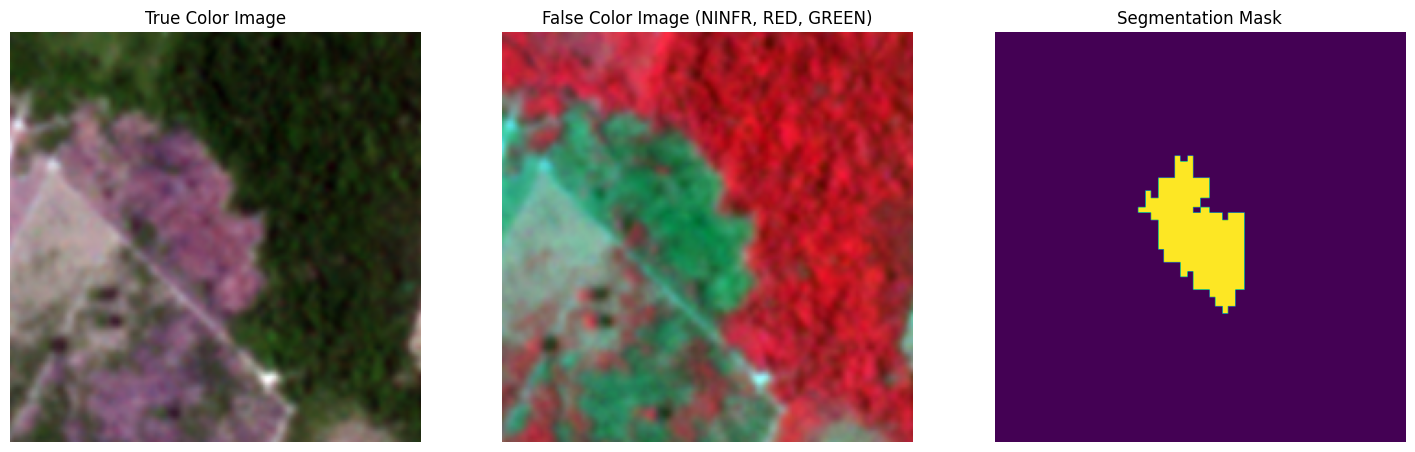

In [25]:
illustrate_data_loader(train_loader, 10)

In [ ]:
illustrate_data_loader(val_loader, 5)

In [ ]:
illustrate_data_loader(test_loader, 5)

#### Illustrate distribution of raw values across bands

In [ ]:
dataset = PlanetDataset(data_dir=DATA_PATH, bands=[0,1,2,3])
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0)
dataloader = iter(dataloader)

In [ ]:
sample, mask = next(dataloader)
for batch_num in range(4):
    plot_band_distribution(sample[batch_num,:,:,:])

In [ ]:
# pre-calculated means, std, mins, max of raw images calculated on the full test set:
means = torch.tensor([ 265.7371,  445.2234,  393.7881, 2773.2734])
stds = torch.tensor([ 91.8786, 110.0122, 191.7516, 709.2327])
mins = torch.tensor([ 0., 21.,  6., 77.])
max = torch.tensor([ 4433.,  5023.,  8230., 10000.])

"""
means = torch.mean(train_sample.float(), dim=(0, 1, 2))
std = torch.std(train_sample.float(), dim=(0, 1, 2))
min = torch.amin(train_sample.float(), dim=(0, 1, 2))
max = torch.amax(train_sample.float(), dim=(0, 1, 2))
"""

### MLE Predictions based on Mutlivariate Gauassian

In [ ]:
train_loader, val_loader, test_loader = create_dataloaders(DATA_PATH, bands=[0, 1, 2, 3], batch_size=2000, transforms=True) # get full train and val dataset

In [ ]:
def prepare_data(X_in, y_in):
    X_out = torch.permute(X_in, (1, 0, 2, 3)).flatten(start_dim=1).T
    y_out = y_in.flatten(start_dim=0)

    assert X_out.shape[0] == len(y_out)
    print("Dimensions of transformed output: ")
    print("Data: {}".format(X_out.shape))
    print("Labels: {}".format(y_out.shape))
    return X_out, y_out

def pull_train_loader(loader, n_pulls):
    image_batches = []
    mask_batches = []
    for _ in range(n_pulls):
        batch_x, batch_y = next(iter(loader))
        image_batches.append(batch_x)
        mask_batches.append(batch_y)

    X = torch.cat(image_batches, 0)
    y = torch.cat(mask_batches, 0)
    return X, y

In [ ]:
X_train, y_train = pull_train_loader(train_loader, 1)
X_test, y_test = next(iter(test_loader))
X_val, y_val = next(iter(val_loader))

X_train, y_train = prepare_data(X_train, y_train)
X_test, y_test = prepare_data(X_test, y_test)
X_val, y_val = prepare_data(X_val, y_val)

Dimensions of transformed output: 
Data: torch.Size([51681280, 4])
Labels: torch.Size([51681280])
Dimensions of transformed output: 
Data: torch.Size([14199808, 4])
Labels: torch.Size([14199808])
Dimensions of transformed output: 
Data: torch.Size([15002624, 4])
Labels: torch.Size([15002624])


In [ ]:
import numpy as np

class MLE_model():
    def __init__(self, ):
        self.pos_means = None
        self.neg_means = None
        self.pos_cov = None
        self.neg_cov = None

    def fit(self, X_train, y_train):
        
        # seperate data into both classes
        pos = (y_train==1)
        neg = (y_train==0)

        X_train_pos = X_train[pos, :]
        X_train_neg = X_train[neg, :]

        # fit multivariate gaussian distributions for both classes
        self.pos_means = torch.mean(X_train_pos, dim=0).numpy()
        self.pos_cov = np.cov(X_train_pos.numpy().T)

        self.neg_means = torch.mean(X_train_neg, dim=0).numpy()
        self.neg_cov = np.cov(X_train_neg.numpy().T)

        # validate fitting process
        print("Model Fitted with means {} and {}".format(self.pos_means, self.neg_means))
        print("Covariance matrix are \n {} \n and \n {}".format(self.pos_cov, self.neg_cov))
        return

    def predict(self, X_test):

        # convert to numpy
        X_test = X_test.numpy()

        # Run MLE estimator
        # calculate log odds for both classes
        log_ps = [self.compute_log_p_solution(X_test, m, s) for m, s in zip([self.neg_means, self.pos_means], [self.neg_cov, self.pos_cov])]
        
        # take argmax
        assignments = np.argmax(log_ps, axis=0)
        return log_ps, assignments
    
    def compute_log_p_solution(self, X, mean, sigma):
        d = X.shape[1]
        c = -np.log(2 * np.pi) * (d / 2) - 0.5 * np.log(np.linalg.det(sigma))
        A = X - mean
        invSigma = np.linalg.inv(sigma)

        return -0.5 * np.sum(A * (A.dot(invSigma)), axis=1) + c


In [ ]:
# train and predict
model = MLE_model()
model.fit(X_train, y_train)

log_ps, pred_tot = model.predict(X_test)

Model Fitted with means [ 0.6822625   0.36782172  0.78166425 -0.8788853 ] and [-0.20304348 -0.12129579 -0.23176947  0.23182237]
Covariance matrix are 
 [[ 0.71010841  0.57630211  0.53511869 -0.05205195]
 [ 0.57630211  0.67217914  0.44494617  0.30721853]
 [ 0.53511869  0.44494617  0.54180344 -0.09249458]
 [-0.05205195  0.30721853 -0.09249458  0.81447195]] 
 and 
 [[ 0.86351422  0.82389101  0.79794392 -0.22118277]
 [ 0.82389101  0.96052951  0.79318628  0.00406552]
 [ 0.79794392  0.79318628  0.86296276 -0.29343132]
 [-0.22118277  0.00406552 -0.29343132  0.72401366]]


In [ ]:
# evaluate on test set
from sklearn.metrics import accuracy_score, jaccard_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, pred_tot)   
jaccard = jaccard_score(y_test, pred_tot, average='binary') # equivalent to IOU
precision = precision_score(y_test, pred_tot, average='binary')
recall = recall_score(y_test, pred_tot, average='binary')
f1 = f1_score(y_test, pred_tot, average='binary') # equivalent to Dice index

print("Accuracy: {:.4}".format(accuracy))
print("F1: {:.4}".format(f1))
print("Jaccard: {:.4}".format(jaccard))
print("Precision: {:.4}".format(precision))
print("Recall: {:.4}".format(recall))

Accuracy: 0.8097
F1: 0.7526
Jaccard: 0.6034
Precision: 0.7335
Recall: 0.7728


In [ ]:
# evaluate on val set
log_ps, pred_tot = model.predict(X_val)

accuracy = accuracy_score(y_val, pred_tot)   
jaccard = jaccard_score(y_val, pred_tot, average='macro') # equivalent to IOU
precision = precision_score(y_val, pred_tot, average='macro')
recall = recall_score(y_val, pred_tot, average='macro')
f1 = f1_score(y_val, pred_tot, average='macro') # equivalent to Dice index

print("Accuracy: {:.4}".format(accuracy))
print("F1: {:.4}".format(f1))
print("Jaccard: {:.4}".format(jaccard))
print("Precision: {:.4}".format(precision))
print("Recall: {:.4}".format(recall))

Accuracy: 0.8293
F1: 0.7886
Jaccard: 0.6608
Precision: 0.7828
Recall: 0.7955


In [ ]:
# training performance
log_ps, pred_tot = model.predict(X_train)

accuracy = accuracy_score(y_train, pred_tot)   
jaccard = jaccard_score(y_train, pred_tot, average='macro') # equivalent to IOU
precision = precision_score(y_train, pred_tot, average='macro')
recall = recall_score(y_train, pred_tot, average='macro')
f1 = f1_score(y_train, pred_tot, average='macro') # equivalent to Dice index

print("Accuracy: {:.4}".format(accuracy))
print("F1: {:.4}".format(f1))
print("Jaccard: {:.4}".format(jaccard))
print("Precision: {:.4}".format(precision))
print("Recall: {:.4}".format(recall))

: 

## Testing unsupervised methods for good measure

In [ ]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=2, verbose=True)

n_samples = 20_000_000
indices = np.random.choice(np.arange(n_samples), size=n_samples)

X_train_ = X_train[indices, :]

model.fit(X_train_)

print("Found means: ", model.means_)
print("Found covariances: ", model.covariances_)

Initialization 0


: 

In [ ]:
pred_tot = model.predict(X_test)

In [ ]:
print(print(pred_tot.mean()))

In [ ]:
# since this is unspervised, we need to flip the class (if accuracy on your machine is bad, just flip it back by rerunning this cell)
pred_tot = np.where(pred_tot==1, 0, 1)

In [ ]:
accuracy = accuracy_score(y_test, pred_tot)
jaccard = jaccard_score(y_test, pred_tot, average='macro') # equivalent to IOU
precision = precision_score(y_test, pred_tot, average='macro')
recall = recall_score(y_test, pred_tot, average='macro')
f1 = f1_score(y_test, pred_tot, average='macro') # equivalent to Dice index

print("Accuracy: {:.4}".format(accuracy))
print("F1: {:.4}".format(f1))
print("Jaccard: {:.4}".format(jaccard))
print("Precision: {:.4}".format(precision))
print("Recall: {:.4}".format(recall))

In [ ]:
# --> we outperform any existing paper and our own NN without even using labels
